In [136]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openai.embeddings_utils import get_embedding, cosine_similarity
import itertools as it


In [38]:
!curl https://api.openai.com/v1/models -H "Authorization: Bearer $OPENAI_API_KEY"|grep gpt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0      "id": "gpt-3.5-turbo-0301",
      "root": "gpt-3.5-turbo-0301",
      "id": "gpt-3.5-turbo",
      "root": "gpt-3.5-turbo",
100 47001  100 47001    0     0  46481      0  0:00:01  0:00:01 --:--:-- 46627
      "id": "gpt-4-0314",
      "root": "gpt-4-0314",
      "id": "gpt-4",
      "root": "gpt-4",


# Lib

In [238]:
def generate_results(inputs, temperature=1, reps=3):
    res = []
    for x in inputs:
        

        for i in range(reps):
            response = openai.Completion.create(
              model="text-davinci-003",
              prompt=x['prompt'],
              temperature=temperature,
              max_tokens=60,
              top_p=1.0,
              frequency_penalty=0.0,
              presence_penalty=0.0,
              logprobs=3,
            )
            text = response['choices'][0]['text']
            res.append(dict(
                text = text,
                emb=get_embedding(text),
                tokens=response['choices'][0]['logprobs']['tokens'],
                token_logprobs=np.array(response['choices'][0]['logprobs']['token_logprobs']),
                top_logprobs=response['choices'][0]['logprobs']['top_logprobs'],
                i=i,
                **x['info']
            ))    
            
    df = pd.DataFrame(res)
    df['logprob_mean']=[np.mean(x) for x in df['token_logprobs'] ]
    df['logprob_std']=[np.std(x) for x in df['token_logprobs'] ]
    return df

# Fake Books

In [183]:
books_fake = ["Bitcoin is the Future","AI Eats Humans", "AI Never Lies", "This Book is Fake"]
books_real = ['Dune', 'The Hobbit', "Reinforcement Learning: An Introduction", "Ender's Game"]

inputs = []
for book in books_fake + books_real:
    is_fake = book in books_fake
    prompt = \
f"""
Who wrote the book "{book}"?  Give you answer as two words <first_name> <last_name>.  Do not break the structure.
"""                    

    inputs.append(dict(
                prompt=prompt,
                info=dict(is_fake=is_fake,
                # i=i,
                book=book)))
df = generate_results(inputs)

In [184]:
df.head()

,text,emb,token_logprobs,top_logprobs,i,is_fake,book,logprob_mean,logprob_std
0,\nLiam McKeown,"[-0.007347103673964739, 0.0032738391309976578,...","[-6.6294406e-06, -4.859679, -0.5931175, -6.405...","[{' ': -6.6294406e-06, ' ': -12.942972, 'Answe...",0,True,Bitcoin is the Future,-2.722004,2.352633
1,\nTommy Mustache,"[-0.012895956635475159, 0.003422413021326065, ...","[-6.6294406e-06, -4.3484273, -0.100348316, -0....","[{' ': -6.6294406e-06, ' ': -12.938951, 'Answe...",1,True,Bitcoin is the Future,-0.986552,1.687278
2,\nJered Kenna.,"[-0.010069557465612888, 0.005647073965519667, ...","[-6.6294406e-06, -4.604989, -3.0771227, -0.040...","[{' ': -6.6294406e-06, ' ': -12.938951, 'Answe...",2,True,Bitcoin is the Future,-1.479506,1.773651
3,\nNamrata Kanodia,"[-0.006804633419960737, 0.00721684331074357, -...","[-6.5092986e-06, -3.6849813, -3.310473, -1.286...","[{' ': -6.5092986e-06, 'Answer': -13.267249, '...",0,True,AI Eats Humans,-1.691167,1.797033
4,\nJohn Ollinger,"[-0.007003334816545248, 0.0037966447416692972,...","[-6.8669196e-06, -3.3211615, -4.563869, -2.892...","[{' ': -6.8669196e-06, 'Answer': -13.186583, '...",1,True,AI Eats Humans,-2.155675,1.843503


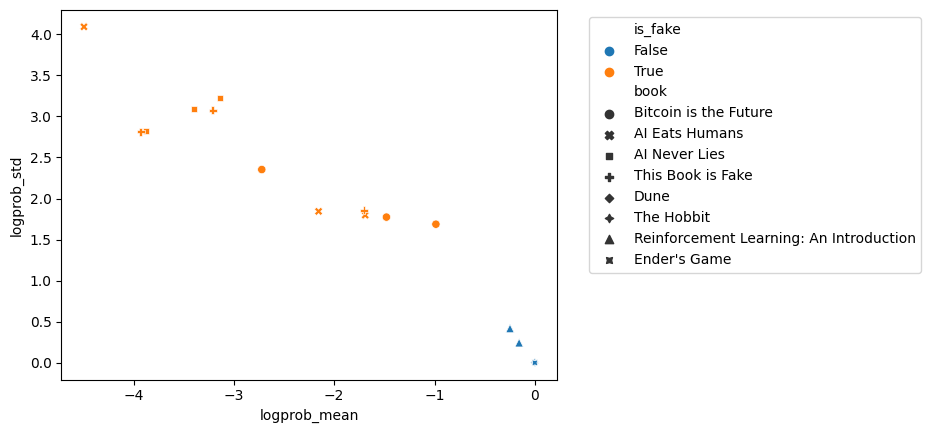

In [186]:
ax = sns.scatterplot(data=df, x='logprob_mean',y='logprob_std',hue='is_fake', style='book')
plt.legend(bbox_to_anchor=(1.05, 1))

# Something more complex

In [293]:
fake = ["write an earnings report for Tesla for Q1 2023", ""]
real = ["Convert 50 yards and 3 miles into the metric system"]

inputs = []
for i, x in enumerate(fake + real):
    is_fake = book in fake
    prompt = \
f"""
{x}
"""                    

    inputs.append(dict(
                prompt=prompt,
                info=dict(is_fake=is_fake,
                x=x)))
df = generate_results(inputs)

In [294]:
df.iloc[2]['text']

'\nTesla, Inc. Earnings Report for Q1 2023\n\nTesla, Inc. recorded strong growth during the first quarter of 2023, as evidenced by strong revenue and net income growth. Revenue for Q1 2023 stood at $33.56 billion, a growth of 32% from'

In [295]:
df.head(3)

,text,emb,tokens,token_logprobs,top_logprobs,i,is_fake,x,logprob_mean,logprob_std
0,\nTesla Inc. is pleased to report its financia...,"[-0.011077984236180782, -0.0001607155427336692...","[\n, Tesla, Inc, ., is, pleased, to, repo...","[-0.0021219274, -0.049162235, -0.66441387, -0....","[{' ': -0.0021219274, 'Tesla': -6.5009108, 'Th...",0,False,write an earnings report for Tesla for Q1 2023,-0.722796,1.096084
1,\nTesla first quarter 2023 earnings report \n\...,"[-0.013070257380604744, -0.00292210909537971, ...","[\n, Tesla, first, quarter, 20, 23, earnin...","[-0.0021059797, -0.049530823, -6.217336, -0.02...","[{' ': -0.0021059797, 'Tesla': -6.517946, 'The...",1,False,write an earnings report for Tesla for Q1 2023,-1.293734,1.806188
2,"\nTesla, Inc. Earnings Report for Q1 2023\n\nT...","[-0.006798746529966593, 0.0013413571286946535,...","[\n, Tesla, ,, Inc, ., Earn, ings, Report, ...","[-0.0020268373, -0.049567025, -2.2920907, -0.0...","[{' ': -0.0020268373, 'Tesla': -6.5514965, 'Th...",2,False,write an earnings report for Tesla for Q1 2023,-1.114026,1.631643


In [296]:
def metrics(t):
    cos = [cosine_similarity(x, y) for x,y in it.product(t['emb'], t['emb']) if x!=y]
    return pd.Series(dict(mean=np.mean(cos)))
    
df.groupby('x').apply(metrics)

,mean
x,
Convert 50 yards and 3 miles into the metric system,0.986732
write an earnings report for Tesla for Q1 2023,0.925545


In [297]:
df['n_unlikely_tokens'] = [ (x<-2).sum() / len(x<-2) for x in df['token_logprobs']]

In [298]:
import math
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as mcm

def create_color_map(min_val, max_val, color_map="viridis"):
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val, clip=True)
    mapper = mcm.ScalarMappable(norm=norm, cmap=mcm.get_cmap(color_map))
    return mapper.to_rgba

def visualize_token_logprobs(token_logprobs, color_map="viridis"):
    min_logprob = min(token_logprobs, key=lambda x: x[1])[1]
    max_logprob = max(token_logprobs, key=lambda x: x[1])[1]
    color_mapper = create_color_map(min_logprob, max_logprob, color_map)

    html = "<p>"
    for token, logprob in token_logprobs:
        color = mcolors.rgb2hex(color_mapper(logprob)[:3])
        html += f'<span style="color: {color};">{token}</span> '
    html += "</p>"

    display(HTML(html))

/var/folders/nw/lktt921x1wg_wt5tfy5q9k2c0000gn/T/ipykernel_24391/234013619.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [299]:
for _,r in df.iterrows():
    number_probs = []
    visualize_token_logprobs(list(zip(r['tokens'], r['token_logprobs'])))


/var/folders/nw/lktt921x1wg_wt5tfy5q9k2c0000gn/T/ipykernel_24391/234013619.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  mapper = mcm.ScalarMappable(norm=norm, cmap=mcm.get_cmap(color_map))


In [303]:
r['top_logprobs']

[<OpenAIObject at 0x2a0f2f920> JSON: {
   "\n": -0.0009269955,
   "50": -7.394748,
   "Con": -9.468971
 },
 <OpenAIObject at 0x2a0f2f970> JSON: {
   " 50": -7.4978666,
   "50": -0.008397834,
   "In": -4.9603305
 },
 <OpenAIObject at 0x2a0664540> JSON: {
   " Yards": -4.958248,
   " y": -7.3375735,
   " yards": -0.00819776
 },
 <OpenAIObject at 0x2a10585e0> JSON: {
   " =": -0.14939517,
   " is": -2.794075,
   ":": -3.0428622
 },
 <OpenAIObject at 0x2a1058680> JSON: {
   " ": -5.9547014,
   " 45": -0.0031420668,
   "45": -9.079255
 },
 <OpenAIObject at 0x2a1058720> JSON: {
   " Met": -9.157677,
   ",": -9.134349,
   ".": -0.0002949793
 },
 <OpenAIObject at 0x2a10587c0> JSON: {
   "7": -3.0932207,
   "72": -0.054099232,
   "73": -5.5062947
 },
 <OpenAIObject at 0x2a1058860> JSON: {
   " Met": -0.074211255,
   " meters": -3.6860406,
   " metres": -3.22756
 },
 <OpenAIObject at 0x2a1058900> JSON: {
   "ers": -0.17534095,
   "re": -9.557345,
   "res": -1.8280699
 },
 <OpenAIObject at 0x2a10

In [291]:
for _,r in df.iterrows():
    number_probs = []
    for x, p in list(zip(r['tokens'], r['token_logprobs'])):
        print(f'{x}[{p:.1}]', end=' ')
        try:
            float(x.strip())
            number_probs.append(p)
        except:
            pass
    print(r['x'])
    print(number_probs)


[-0.002] Q[-5e+00] 1[-4e-05]  20[-0.04] 23[-1e-05]  Earn[-0.3] ings[-1e-06]  Report[-0.02] 
[-0.7] 
[-0.01] Tesla[-0.2]  has[-3e+00]  reported[-1e+00]  its[-3e+00]  Q[-1e+00] 1[-4e-05]  20[-0.2] 23[-6e-06]  financial[-0.9]  results[-0.2] ,[-0.4]  and[-1e+00]  is[-5e+00]  pleased[-0.3]  to[-0.01]  report[-1e+00]  strong[-1e+00]  growth[-1e+00]  and[-2e+00]  positive[-3e+00]  results[-2e+00] .[-0.5] 
[-0.5] 
[-0.0002] For[-4e+00]  the[-0.1]  first[-1e+00]  quarter[-0.01]  of[-0.1]  20[-0.05] 23[-6e-06] ,[-0.003]  Tesla[-0.2]  reported[-0.5]  net[-4e+00]  revenues[-1e+00]  of[-0.005]  $[-0.01] 34[-5e+00] .[-0.1] 28[-7e+00]  billion[-0.01] ,[-0.03]  up[-1e+00]  36[-4e+00] .[-0.9] 2[-2e+00] %[-0.06]  year[-1e+00] -[-0.2] write an earnings report for Tesla for Q1 2023
[-3.690939e-05, -0.04445833, -1.2828294e-05, -4.275062e-05, -0.24046524, -6.031526e-06, -0.04678236, -6.2699432e-06, -5.248309, -6.9661226, -4.2476068, -1.8480843]

[-0.002] Tesla[-0.05]  Inc[-0.7] .[-0.05]  is[-0.7]  pleased[